## Classifying Politicians
Your goal is to test the performance of spectral clustering and a simple semi-supervised regression algorithm on the 1984 house voting records data set. Download the data set called house-votes-84.data, and the description house-votes-84.names. The data set consists of voting records of 435 members of the House on 16 bills. There are 267 members of the democratic party and 168 members of the republican party. The voting record of each house member on the 16 bills will be our input x while the corresponding output/class 𝑦 is that members party affiliation (republican or democrat embedded as ±1).

#### Task 1

Your first task is to import and preprocess the data set. Construct your output vector y by assigning labels {−1, +1} to members of different parties. Then construct the input vectors x𝑗 corresponding to the voting records of each member by replacing ’y’ votes with +1, ’n’ votes with −1 and ’?’ with 0. You do not need to center and normalize the data set in this case. This leads to a vector y ∈ R435 and input matrix 𝑋 ∈ R435×16. Note that we are using the sklearn convention for our 𝑋 matrix.

In [182]:
import numpy as np
import matplotlib.pyplot as plt

In [183]:
votes = (np.loadtxt('house-votes-84.data', delimiter = ',', dtype =object, unpack=True)).T
votes.shape

(435, 17)

In [184]:
temp_y = [item[0] for item in votes]

d = dict([(y,x+1) for x,y in enumerate(sorted(set(temp_y)))])
temp_y = [d[x] for x in temp_y]

Y = [-1 if x==2 else x for x in temp_y]

In [185]:
temp_x = np.array([item[1:] for item in votes])

temp_x[ temp_x == '?' ] = 0 
temp_x[ temp_x == 'y' ] = 1
temp_x[ temp_x == 'n' ] = -1

In [186]:
temp_x.shape

(435, 16)

#### Task 2 (Spectral Clustering)

In [6]:
import scipy as sp
from sklearn.linear_model import Ridge
import scipy.spatial

In [11]:
def eta(t, l):
    val = np.exp(-(1/(2*l**2))*t**2 )
    return val

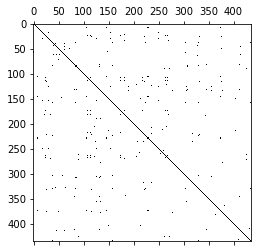

In [12]:
# construct unnormalized graph Laplacian on features
dist = sp.spatial.distance_matrix( temp_x, temp_x )

l = 0.05*dist.mean() # l length scale of the kernel 
W = eta(dist, l)

plt.spy(W>= 1e-4)
plt.show()

In [44]:
# compute Laplacian matrices 

d = np.sum(W, axis=1) # degree vector

D = np.diag(d)
Ds = np.diag(1/np.sqrt(d))
Di = np.diag(1/d)


L = D - W # unnormalized

In [87]:
# compute eigendecompositions 

ll, VV = np.linalg.eigh(L)

# we need to sort the eigenvalues and vectors 

idx = ll.argsort()
l = ll[idx]
V = VV[:, idx]

fiedler_vector = V[:,1]
sign_fiedler_vector = np.sign(V[:,1])

In [96]:
difference = sign_fiedler_vector - Y
n_zeros = np.count_nonzero(difference==0)
clustering_accuracy = n_zeros/435

clustering_accuracy

0.4

<ipython-input-68-536fd31e07b6>:5: RuntimeWarning: invalid value encountered in log
  ax.plot(np.log(l[1:None]))


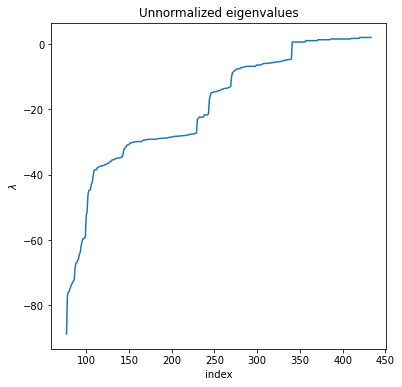

In [68]:
# plot eigenvalues 
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.plot(np.log(l[1:None]))
ax.set_title('Unnormalized eigenvalues')
ax.set_xlabel('index')
ax.set_ylabel('$\lambda$')
plt.show()

Change the parameter 𝜎 in the range (0, 4] and plot accuracy as a function of 𝜎. Let 𝜎* denote the optimal variance parameter achieving maximum clustering accuracy. Discuss your findings.

In [98]:
clustering_accuracy_w_sigma = []
sigmas = np.arange(1,5,0.01)

for l in sigmas:
    W = eta(dist, l)
    D = np.diag(np.sum(W,axis=1))
    L = D - W 

    ll, VV = np.linalg.eigh(L) # compute eigendecompositions 

    # we need to sort the eigenvalues and vectors 
    idx = ll.argsort()
    l = ll[idx]
    V = VV[:, idx]
    
    fiedler_vector = V[:,1]
    
    sign_fiedler_vector = np.sign(V[:,1])

    Y = np.asarray(Y)
    
    difference = sign_fiedler_vector - Y
    n_zeros = np.count_nonzero(difference==0)
    clustering_accuracy = n_zeros/435
    clustering_accuracy_w_sigma.append(clustering_accuracy)

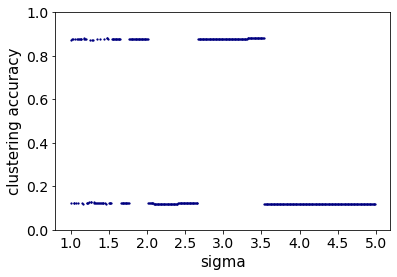

In [117]:
plt.scatter(sigmas, clustering_accuracy_w_sigma, s=1.5,c='navy')
plt.xlabel('sigma',fontsize=15)
plt.ylabel('clustering accuracy',fontsize=15)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.ylim(0,1.)
plt.show()

In [112]:
print(sigmas[np.argmax(clustering_accuracy_w_sigma)])
print(np.nanmax(clustering_accuracy_w_sigma))

1.1700000000000002
0.8804597701149425


#### Task 3 (Semi-supervised Learning)

Now consider the unnormalized Laplacian from Step 2 with the optimal parameter 𝜎* that you picked.

In [473]:
def return_subset( dig1, dig2, XX, YY ):
#function to take subset of data set
    indx1 = np.argwhere( YY == dig1 )
    indx2 = np.argwhere( YY == dig2 )
    indx = np.append(indx1, indx2, axis=0)
    indx = np.random.permutation(indx.flatten())

    XX_sub = XX[indx, :]
    YY_sub = YY[indx]

    b = np.zeros( (len(indx), 2))
    for j in range(len(YY_sub)):
        if YY_sub[j] == dig1:
            b[j,:] = [1, 0 ]
        elif YY_sub[j] == dig2:
            b[j, :] = [0, 1]
    return XX_sub, YY_sub, b

In [427]:
digit1 = -1; digit2 = 1

M = 10; J = 3

X, Y, hidden_labels = return_subset( digit1, digit2, temp_x, np.asarray(Y) )
labels = hidden_labels[0:M, :]

In [428]:
optimal_sigma = sigmas[np.argmax(clustering_accuracy_w_sigma)]

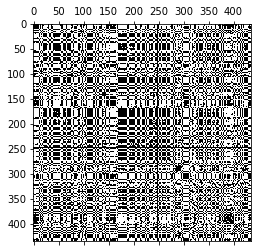

In [429]:
W = eta(dist, optimal_sigma)

plt.spy(W>= 1e-4)
plt.show()

In [430]:
# compute Laplacian matrices 
d = np.sum(W, axis=1) # degree vector
D = np.diag(d)
Ds = np.diag(1/np.sqrt(d))
Di = np.diag(1/d)

L = D - W # unnormalized

# compute eigendecompositions 

ll, VV = np.linalg.eigh(L)

# we need to sort the eigenvalues and vectors 

idx = ll.argsort()
l = ll[idx]
V = VV[:, idx]

In [435]:
# might be unnecessary here
vectors = []
for i in range(M):
    vectors.append(V[:,i])
    
vectors = np.asarray(vectors).T

b = labels[:J]

matrix_A = vectors[0:J, 0:M] #Given an integer 𝐽 ≥ 1 consider the submatrix 𝐴 ∈ R 𝐽×𝑀
print(matrix_A.shape)
print(Vp.shape)
print(b.shape)
print(labels.shape)

(3, 10)
(10, 3)
(3, 2)
(10, 2)


In [469]:
SSLRidge = Ridge(alpha = 1e-8)

SSLRidge.fit( matrix_A, b )

beta = np.zeros((10,2)) # we have three classes so beta is now a matrix
# # print(beta.shape)
beta[0, :] = SSLRidge.intercept_
len_to_use = np.transpose(SSLRidge.coef_).shape[0]
print(len_to_use)
beta[0:(len_to_use+1), :] = np.transpose(SSLRidge.coef_)
print(beta)

10
[[ 1.84432880e-13 -1.84432880e-13]
 [ 1.42324913e+01 -1.42324913e+01]
 [-1.45727818e-01  1.45727818e-01]
 [-1.93325797e+01  1.93325797e+01]
 [-6.53059017e+00  6.53059017e+00]
 [-9.21987920e+00  9.21987920e+00]
 [-5.18061880e+00  5.18061880e+00]
 [-1.60153805e+01  1.60153805e+01]
 [ 3.45534221e+00 -3.45534221e+00]
 [-3.05429227e+01  3.05429227e+01]]


In [470]:
labels_pred = np.dot(A, beta)
classes_pred = np.argmax(labels_pred, axis= 1)

(435,)
(435, 2)
(435, 2)


Text(0.5, 1.0, 'Predicted labels')

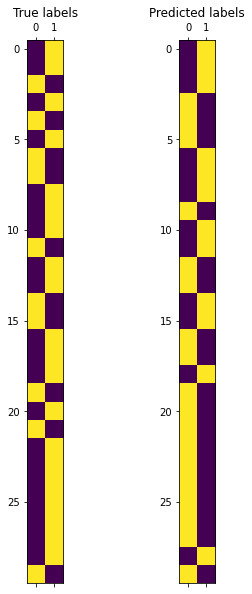

In [471]:
# threshold predicted labels to one-hot format
labels_pred_max = np.amax(labels_pred, axis=1)

print(labels_pred_max.shape)

import numpy.matlib

print(labels_pred.shape)
labels_pred_max = np.transpose(np.matlib.repmat(labels_pred_max, 2, 1))
print(labels_pred_max.shape)

labels_pred_thresholded = (labels_pred == labels_pred_max).astype(float)
fig, ax = plt.subplots(1, 2, figsize=(5, 10))

ax[0].matshow(hidden_labels[0:30, :])
ax[0].set_title('True labels')

ax[1].matshow(labels_pred_thresholded[0:30, :])
ax[1].set_title('Predicted labels')

In [472]:
err = 0

print(hidden_labels.shape)
print(labels_pred_thresholded.shape)


for i in range(len(hidden_labels)):
  # count number of mislabelled images 
  err+= 1- np.array_equal( hidden_labels[i,:], labels_pred_thresholded[i, :])

mislabelled_ratio = err/len(hidden_labels)

print('mislablled ratio:', mislabelled_ratio)

(435, 2)
(435, 2)
mislablled ratio: 0.4896551724137931


In [457]:
np.transpose(SSLRidge.coef_).shape

(10, 2)

In [436]:
Vp = V[0:M, 0:J]
print(Vp.shape)

(10, 3)


In [421]:
# Ridge regression on labelled set 
SSLRidge = Ridge(alpha = 1e-8)

SSLRidge.fit( Vp, labels )

beta = np.zeros((K,2)) # we have three classes so beta is now a matrix
print(beta.shape)
beta[0, :] = SSLRidge.intercept_
len_to_use = np.transpose(SSLRidge.coef_).shape[0]
beta[1:(len_to_use+1), :] = np.transpose(SSLRidge.coef_)
print(beta)

(10, 2)
[[-4.58965944e+00  5.58965944e+00]
 [-2.30016153e-07  2.30016153e-07]
 [-4.96793590e+01  4.96793590e+01]
 [-1.86784507e+03  1.86784507e+03]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]]


In [462]:
A = V[:, 0:K]
print(A.shape)

(435, 10)


In [423]:
labels_pred = np.dot(A, beta)
classes_pred = np.argmax(labels_pred, axis= 1)

(435,)
(435, 2)
(435, 2)


Text(0.5, 1.0, 'Predicted labels')

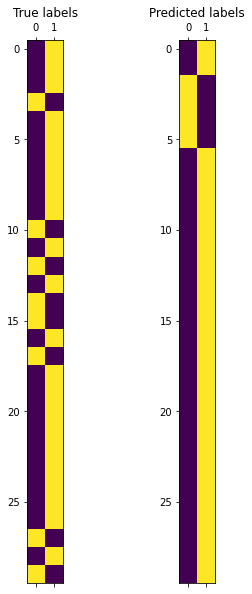

In [424]:
# threshold predicted labels to one-hot format
labels_pred_max = np.amax(labels_pred, axis=1)

print(labels_pred_max.shape)

import numpy.matlib

print(labels_pred.shape)
labels_pred_max = np.transpose(np.matlib.repmat(labels_pred_max, 2, 1))
print(labels_pred_max.shape)

labels_pred_thresholded = (labels_pred == labels_pred_max).astype(float)
fig, ax = plt.subplots(1, 2, figsize=(5, 10))

ax[0].matshow(hidden_labels[0:30, :])
ax[0].set_title('True labels')

ax[1].matshow(labels_pred_thresholded[0:30, :])
ax[1].set_title('Predicted labels')

In [425]:
err = 0

print(hidden_labels.shape)
print(labels_pred_thresholded.shape)


for i in range(len(hidden_labels)):
  # count number of mislabelled images 
  err+= 1- np.array_equal( hidden_labels[i,:], labels_pred_thresholded[i, :])

mislabelled_ratio = err/len(hidden_labels)

print('mislablled ratio:', mislabelled_ratio)

(435, 2)
(435, 2)
mislablled ratio: 0.4160919540229885


In [398]:
## --------------------------------------------------------------------------------------------------
## miscellaneous notes
## --------------------------------------------------------------------------------------------------

# M = 2, J = 10
# dem = np.where(labels == -1)
# rep = np.where(labels == 1)

# ax.scatter( V[dem,1]/np.abs(V[:,1]).max(), V[dem,2]/np.abs(V[:,2]).max(), V[dem,3]/np.abs(V[:,3]).max(),
#           label = 'democrat')
# ax.scatter( V[rep,1]/np.abs(V[:,1]).max(), V[rep,2]/np.abs(V[:,2]).max(), V[rep,3]/np.abs(V[:,3]).max() , 
#           'r0', label = 'republican')